# Лабораторная работа №4
## по предмету "Системы искусственного интеллекта"
### БВТ2101 Артём Юдин

Целью работы является введение и знакомство с нейронными сетями.


In [20]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
import torchvision
from torchvision.transforms import v2
from keras.datasets import mnist

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import numpy.typing as npt
from collections import Counter, abc as cabc

In [21]:
BATCH_SIZE = 32
EPOCHS = 10
DEVICE = "cuda:0" if torch.cuda.is_available() else "cpu"

### Задание 1

Загрузите набор данных MNIST.
Проверьте баланс классов, нормализуйте данные.

In [22]:
transforms = v2.Compose(
    [
        v2.ToImage(),
        v2.Resize(size=[32], interpolation=v2.InterpolationMode.BICUBIC),
        v2.ToDtype(torch.float32, scale=True),
    ]
)

train_dataset = torchvision.datasets.MNIST(
    root="./tmp", train=True, download=True, transform=transforms
)
test_dataset = torchvision.datasets.MNIST(
    root="./tmp", train=False, download=True, transform=transforms
)

7

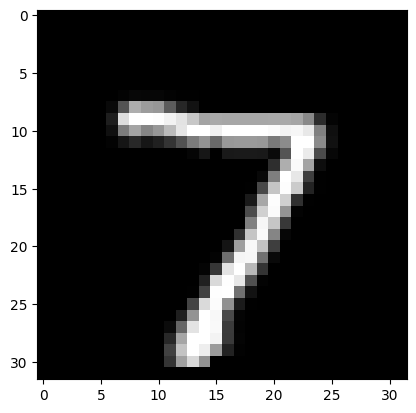

In [23]:
plt.imshow(
    test_dataset[0][0].view(
        test_dataset[0][0].shape[2],
        test_dataset[0][0].shape[1],
        test_dataset[0][0].shape[0],
    ),
    cmap="gray",
)
test_dataset[0][1]

/opt/conda/lib/python3.10/site-packages/torchvision/datasets/mnist.py:66: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


<Axes: >

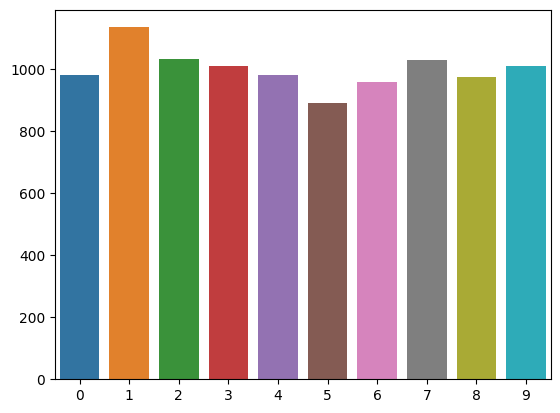

In [24]:
sns.barplot(
    x=list(range(10)),
    y=[
        y[1]
        for y in sorted(
            Counter(test_dataset.train_labels.numpy()).items(), key=lambda x: x[0]
        )
    ],
)

In [25]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train / 255.0
X_test = X_test / 255.0

X_train_flat = X_train.reshape(X_train.shape[0], X_train.shape[1] * X_train.shape[2])
X_test_flat = X_test.reshape(X_test.shape[0], X_test.shape[1] * X_test.shape[2])

### Задание 2

Реализуйте однослойный перцептрон с применением алгоритма градиентного спуска для обучения.

In [26]:
def get_acc(y_pred: np.ndarray, y_true: np.ndarray) -> float:
    return np.sum(np.argmax(y_pred, axis=1) == y_true) / y_true.shape[0]


class LogisticRegression:
    def __init__(self) -> None:
        self.w = None

    def _ohe(self, y: np.ndarray) -> np.ndarray:
        y_ohe = np.zeros((y.shape[0], np.unique(y).shape[0]))
        y_ohe[np.arange(y.size), y] = 1
        return y_ohe

    def _softmax(self, preds: np.ndarray) -> np.ndarray:
        preds = np.log(np.maximum(preds, 1e-9))
        return np.exp(preds) / np.sum(np.exp(preds))

    def predict(self, X: np.ndarray) -> np.ndarray:
        return self._softmax(X @ self.w)

    def fit(
        self, X: npt.ArrayLike, y: npt.ArrayLike, epochs: int = 10, lr: float = 1e-2
    ) -> None:
        X = np.array(X)
        y = np.array(y)
        y = self._ohe(y)

        if self.w is None:
            self.w = np.random.random((X.shape[1], y.shape[1]))

        for epoch in range(epochs):
            print(f"Epoch {epoch}")
            for X_s, y_s in zip(X, y):
                probs = self.predict(X_s)
                grads = np.expand_dims(X_s, axis=0).T @ np.expand_dims(
                    (probs - y_s), axis=0
                )
                self.w -= grads * lr


model = LogisticRegression()
model.fit(X_train_flat, y_train, epochs=EPOCHS)
get_acc(model.predict(X_test_flat), y_test)

Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9


0.8568

### Задание 3

Изучите документацию библиотеки PyTorch, посмотрите, как создаются сверточные, полносвязные слои и слои пуллинга. Напишите свою нейронную сеть, поэксперементируйте со слоями. Обучите ее на основе набора данных MNIST.

In [30]:
class LeNet5(nn.Module):
    def __init__(self) -> None:
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.avg1 = nn.AvgPool2d(2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.avg2 = nn.AvgPool2d(2)
        self.conv3 = nn.Conv2d(16, 120, 5)

        self.fc1 = nn.Linear(120, 84)
        self.fc2 = nn.Linear(84, 10)

        self.act = nn.Tanh()

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        X = self.act(self.conv1(X))
        X = self.avg1(X)

        X = self.act(self.conv2(X))
        X = self.avg2(X)

        X = self.act(self.conv3(X))
        X = X.flatten(start_dim=1)

        X = self.act(self.fc1(X))
        out = self.fc2(X)
        return out


model = LeNet5().to(DEVICE)
optimizer = optim.Adam(model.parameters(), 1e-3)
criterion = nn.CrossEntropyLoss()
model


LeNet5(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (avg1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (avg2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv3): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=120, out_features=84, bias=True)
  (fc2): Linear(in_features=84, out_features=10, bias=True)
  (act): Tanh()
)

In [28]:
train_dl = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    pin_memory=torch.cuda.is_available(),  # only with GPU
    num_workers=2,
    drop_last=True,
)

test_dl = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    pin_memory=torch.cuda.is_available(),  # only with GPU
    num_workers=2,
    drop_last=True,
)

In [31]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc


def train_step(
    model: nn.Module,
    criterion: nn.Module,
    optimizer: optim.Optimizer,
    data_loader: DataLoader,
    accuracy_fn: cabc.Callable[[torch.Tensor, torch.Tensor], torch.Tensor],
    device: torch.device | str = DEVICE,
):
    train_loss, train_acc = 0, 0
    model.train()
    for X, y in data_loader:
        X, y = X.to(device), y.to(device)
        y_pred = model(X)
        loss = criterion(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")


def test_step(
    model: nn.Module,
    criterion: nn.Module,
    data_loader: DataLoader,
    accuracy_fn: cabc.Callable[[torch.Tensor, torch.Tensor], torch.Tensor],
    device: torch.device | str = DEVICE,
):
    test_loss, test_acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)
            test_pred = model(X)
            test_loss += criterion(test_pred, y)
            test_acc += accuracy_fn(y_true=y, y_pred=test_pred.argmax(dim=1))

        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")


for epoch in range(EPOCHS // 2):
    train_step(
        data_loader=train_dl,
        model=model,
        criterion=criterion,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn,
        device=DEVICE,
    )
    test_step(
        data_loader=test_dl,
        model=model,
        criterion=criterion,
        accuracy_fn=accuracy_fn,
        device=DEVICE,
    )

Train loss: 0.23400 | Train accuracy: 92.97%
Test loss: 0.09455 | Test accuracy: 97.04%

Train loss: 0.07686 | Train accuracy: 97.65%
Test loss: 0.06736 | Test accuracy: 97.88%

Train loss: 0.05677 | Train accuracy: 98.23%
Test loss: 0.05889 | Test accuracy: 98.19%

Train loss: 0.04242 | Train accuracy: 98.68%
Test loss: 0.04897 | Test accuracy: 98.52%

Train loss: 0.03502 | Train accuracy: 98.90%
Test loss: 0.04738 | Test accuracy: 98.57%

